### 2023.07.07 : TSA_01_(Adfuller_TEST)
- data를 Load 하고 기본적인 transform을 진행하여 모델에 입력 가능하도록 정비한다.

### 2023.07.07 : TSA_01
- Adfuller stationary (Dickey Fuller) Test 확인
- 전체 데이터를 하나의 frame으로 묶어야 하는가?
- transform을 하기 위한 정보 dict 를 만들어야 하는가?

### 2023.07.10 : TSA_02
- lag를 반영하는 정상성 확보 변환 계열을 로드한다.
- 로드한 데이터를 em-DFM 모델에 입력하고 소스자료에 따라 분석을 진행한다.

### 2023.07.11 : TSA_02_02
- lag를 반영하는 정상성 확보 변환 계열을 로드한다.
  > - data loader 에서 반영 필요
  > - outlier에 대한 반영도 추가
- factor order 에 대한 설정 확인.
- 로드한 데이터를 em-DFM 모델에 입력하고 소스자료에 따라 분석을 진행한다.



In [ ]:
# colab 한글 font 사용을 위한 font 설치
# install 후 restart session
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# os.chdir(r'D:\2023\Sadj\x13as_ascii-v1-1-b59\x13as')
from datetime import datetime as dt
import time

import types
import numpy as np
import pandas as pd
import openpyxl
import pprint as pp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Python set up modules loaded")
print("Python version:\n", os.sys.version, "\nPlatform: ", os.sys.platform)
print("Base directory path:", os.getcwd())
print("Data/time:", dt.now())

import statsmodels as sma
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# from statsmodels.tsa.x13 import x13_arima_select_order, _find_x12 # local에서 x13_arima_seats를 이용하여 계절조정 필요한 계열에 적용하였음.

print("STATSMODELS info (statsmodels._version.version)", sma._version.version)
# v0.13.0 만 json version 정보 있음. v0.14.0 부터 없음.

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
%matplotlib inline
import seaborn as sns

Python set up modules loaded
Python version:
 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0] 
Platform:  linux
Base directory path: /content
Data/time: 2023-07-11 17:47:31.673788
STATSMODELS info (statsmodels._version.version) 0.13.5


In [7]:

# function
def adf_test(transformed):
    if (result := adfuller(transformed.values))[1] < 0.05:
        test_result = "{}".format("S")
    else:
        test_result = "{}".format("N")
    return test_result

def transform(df, var_info, start, end, feq):
    for col in df.columns:
        # print(f"col : {col}")
        # print(f"var_info id : {var_info[var_info['ID'] == col]}")
        # print(f"var_info id's transform: {var_info[var_info['ID'] == col]['transform'].values[0]}")
        diff = var_info[var_info['ID'] == col]['transform'].values[0]
        lag = var_info[var_info['ID'] == col]['LAG'].values[0]
        print(f"lag: {lag}, type: {type(lag)}")
        raise
        df_trans = df.copy()
        # transform N test
        if diff == 'Origin':
            transformed = df[col].loc[start:end].dropna()
            res = adf_test(transformed)
            df_trans[col] = transformed
        elif diff == 'Diff-1':
            transformed = df[col].loc[start:end].diff().dropna()
            res = adf_test(transformed)
            df_trans[col] = transformed
        elif diff == 'Log-1':
            # error transform log list
            if col in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']:
                res = 'X'
            else:
                log_1 = df[col].loc[start:end]
                transformed = np.log(log_1).dropna()
                res = adf_test(transformed)
                df_trans[col] = transformed
        elif diff == 'Diff-2':
            transformed = df[col].loc[start:end].diff().diff().dropna()
            res = adf_test(transformed)
            df_trans[col] = transformed
        else:
            print(f"transformation not orderred")

        # if res == 'N' or res == 'X':
            # return print(f"transformed data column variable stationary Adfuller Test is fail: {res}")
    return df_trans


def load_data_DFM(data_path, start, end):
    # load data
    # Quatery
    df_Q = pd.read_excel(data_path, index_col='date', sheet_name='df_Q', header=0)
    p_rng_q = pd.period_range('1960Q2', '2023Q1', freq='Q-FEB')
    df_Q = df_Q.set_index(p_rng_q)
    df_Q = df_Q.iloc[:,1:].astype('float')
    df_Q.index.name = 'date'
    # Monthly
    df_M = pd.read_excel(data_path, index_col='date', sheet_name='df_M', header=0)
    p_rng_m = pd.period_range('1970-01-01', '2023-06-01', freq='m')
    df_M = df_M.set_index(p_rng_m)
    df_M = df_M.iloc[:,1:].astype('float')
    df_M.index.name = 'date'
    # Variable Info
    var_info = pd.read_excel(data_path, sheet_name='df_var_info', header=0)
    # diff transform for stationary
    df_Q_trans = transform(df_Q, var_info, start, end, 'Q')
    df_M_trans = transform(df_M, var_info, start, end, 'M')
    return df_Q_trans, df_M_trans, var_info


# Nueral Network  Model dataloader
def load_data_NN(data_path):
    # load data
    df_Q = pd.read_excel(data_path, sheet_name='df_Q', header=0)
    df_M = pd.read_excel(data_path, sheet_name='df_M', header=0)
    var_info = pd.read_excel(data_path, sheet_name='df_var_info', header=0)

    return df_Q, df_M, var_info

def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean()
    iqr = dta.quantile([0.25, 0.75]).diff().T.iloc[:, 1]

    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

In [8]:
# data for function test
path = '/content/drive/MyDrive/ZZ/Code_02/Base_data'
file = 'dataset_03_S.xlsx'
data_path = os.path.join(path, file)
start = '2007-01'
end = '2023-03'

df_Q_trans, df_M_trans, var_info= load_data_DFM(data_path,start,end)


lag: 2, type: <class 'numpy.int64'>


RuntimeError: ignored

<Figure size 1000x300 with 0 Axes>

<Axes: xlabel='date'>

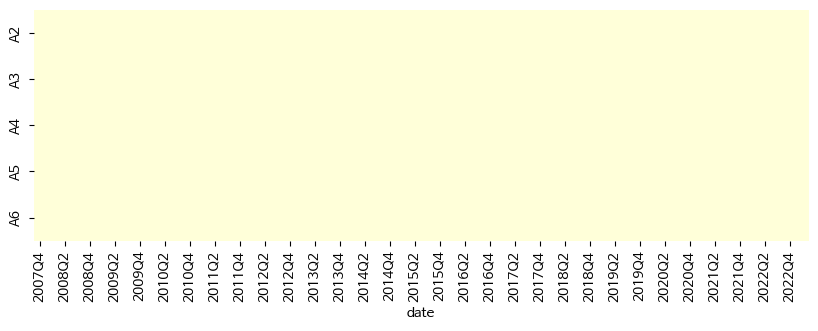

In [ ]:
# check null
plt.figure(figsize=(10,3))
sns.heatmap(df_Q_trans.loc[start:end].isna().transpose(),
            cmap="YlGnBu",
            cbar=False,
            # cbar_kws={'label': 'Missing Data'}
            )
plt.show()

<Figure size 1000x300 with 0 Axes>

<Axes: xlabel='date'>

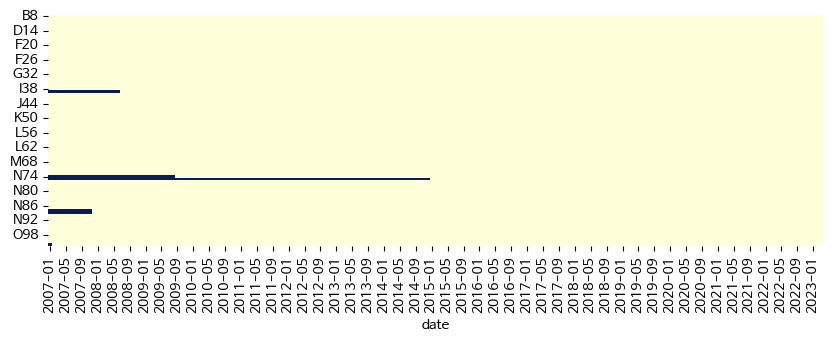

In [ ]:
plt.figure(figsize=(10,3))
sns.heatmap(df_M_trans.loc[start:end].isna().transpose(),
            cmap="YlGnBu",
            cbar=False,
            # cbar_kws={'label': 'Missing Data'}
            )
plt.show()

In [ ]:
endog_m = df_M_trans.loc[start:,:]
endog_q = df_Q_trans.loc[start:,:]


In [ ]:
factors = {
        'A1':['Global'],
        'A2':['Global','Customer'],
        'A3':['Global','Company'],
        'A4':['Global','Company'],
        'A5':['Global','Trade'],
        'A6':['Global','Trade'],
        'B7':['Global','Economic'],
        'B8':['Global','Economic'],
        'C9':['Global','Company'],
        'C10':['Global','Company'],
        'C11':['Global','Company'],
        'C12':['Global','Company'],
        'D13':['Global','Company','Economic'],
        'D14':['Global','Company','Economic'],
        'D15':['Global','Company','Economic'],
        'E16':['Global','Customer','Economic'],
        'E17':['Global','Customer','Economic'],
        'E18':['Global','Customer','Economic'],
        'E19':['Global','Customer','Economic'],
        'F20':['Global','Company','Economic'],
        'F21':['Global','Company','Economic'],
        'F22':['Global','Company','Economic'],
        'F23':['Global','Customer','Economic'],
        'F24':['Global','Customer','Economic'],
        'F25':['Global','Customer','Economic'],
        'F26':['Global','Customer','Economic'],
        'F27':['Global','Customer','Economic'],
        'F28':['Global','Customer','Economic'],
        'F29':['Global','Customer','Economic'],
        'F30':['Global','Customer','Economic'],
        'G31':['Global','Company','	Economic'],
        'G32':['Global','Company','	Economic'],
        'G33':['Global','Company','	Economic'],
        'H34':['Global','Company','	Economic'],
        'H35':['Global','Company','	Economic'],
        'H36':['Global','Company','	Economic'],
        'I37':['Global','Customer','Economic'],
        'I38':['Global','Customer','Economic'],
        'I39':['Global','Customer','Economic'],
        'J40':['Global','Company','Economic'],
        'J41':['Global','Company','Economic'],
        'J42':['Global','Company','Economic'],
        'J43':['Global','Company','Economic'],
        'J44':['Global','Company','Economic'],
        'J45':['Global','Company','Economic'],
        'J46':['Global','Company','Economic'],
        'J47':['Global','Company','Economic'],
        'J48':['Global','Company','Economic'],
        'K49':['Global','Customer','Economic'],
        'K50':['Global','Customer','Economic'],
        'K51':['Global','Customer','Economic'],
        'K52':['Global','Customer','Economic'],
        'L53':['Global','Trade','Economic'],
        'L54':['Global','Trade','Economic'],
        'L55':['Global','Trade','Economic'],
        'L56':['Global','Trade','Economic'],
        'L57':['Global','Trade','Economic'],
        'L58':['Global','Trade','Economic'],
        'L59':['Global','Trade','Economic'],
        'L60':['Global','Trade','Economic'],
        'L61':['Global','Trade','Economic'],
        'L62':['Global','Trade','Economic'],
        'L63':['Global','Trade','Economic'],
        'L64':['Global','Trade','Economic'],
        'L65':['Global','Company','Trade','Economic'],
        'M66':['Global','Trade','Finance'],
        'M67':['Global','Trade','Finance'],
        'M68':['Global','Trade','Finance'],
        'M69':['Global','Trade','Finance'],
        'M70':['Global','Trade','Finance'],
        'N71':['Global','Trade','Finance'],
        'N72':['Global','Customer','Finance'],
        'N73':['Global','Company','Finance'],
        'N74':['Global','Customer','Finance'],
        'N75':['Global','Customer','Finance'],
        'N76':['Global','Company','Finance'],
        'N77':['Global','Company','Finance'],
        'N78':['Global','Company','Finance'],
        'N79':['Global','Company','Finance'],
        'N80':['Global','Company','Finance'],
        'N81':['Global','Company','Finance'],
        'N82':['Global','Company','Finance'],
        'N83':['Global','Finance'],
        'N84':['Global','Finance'],
        'N85':['Global','Finance'],
        'N86':['Global','Finance'],
        'N87':['Global','Customer','Finance'],
        'N88':['Global','Customer','Finance'],
        'N89':['Global','Customer','Finance'],
        'N90':['Global','Company','Finance'],
        'N91':['Global','Company','Finance'],
        'N92':['Global','Customer','Finance'],
        'N93':['Global','Customer','Finance'],
        'O94':['Global','Finance'],
        'O95':['Global','Finance'],
        'O96':['Global','Finance'],
        'O97':['Global','Finance'],
        'O98':['Global','Finance'],
        'O99':['Global','Finance'],
        'O100':['Global','Finance'],
        'O101':['Global','Finance'],
        'O102':['Global','Finance']
}

In [ ]:
factor_orders = {
    ('Customer','Company','Economic','Finance'): 1
    'Global' : 2
}

In [ ]:
# factor_multiplicities = {'Global': 1}

In [ ]:
# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ( endog_m,
                                endog_quarterly=endog_q,
                                factors=factors,
                                factor_orders=factor_orders,
                                factor_multiplicities=factor_multiplicities)

In [ ]:
model.summary()